<a href="https://colab.research.google.com/github/deepanshudaw/Deep-Learning/blob/master/Cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from PIL import Image
import cv2
from keras.applications.xception import Xception
from tensorflow import keras

In [138]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-06-21 15:30:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   118MB/s    in 0.6s    

2019-06-21 15:30:12 (118 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
catlist=os.listdir(train_cats_dir)
doglist=os.listdir(train_dogs_dir)

In [0]:
catimg=[os.path.join(train_cats_dir,fname) for fname in catlist]
dogimg=[os.path.join(train_dogs_dir,fname) for fname in doglist]

In [143]:
#Load and Preprocess Data

image_dim = 150
set_trainable = False


train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=40,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

valid_datagen = ImageDataGenerator( rescale=1./255,
                                    fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(train_dir, target_size=(image_dim,image_dim), classes=['cats', 'dogs'], batch_size = 10)
valid_batches = valid_datagen.flow_from_directory(validation_dir, target_size=(image_dim,image_dim), classes=['cats', 'dogs'], batch_size = 10)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


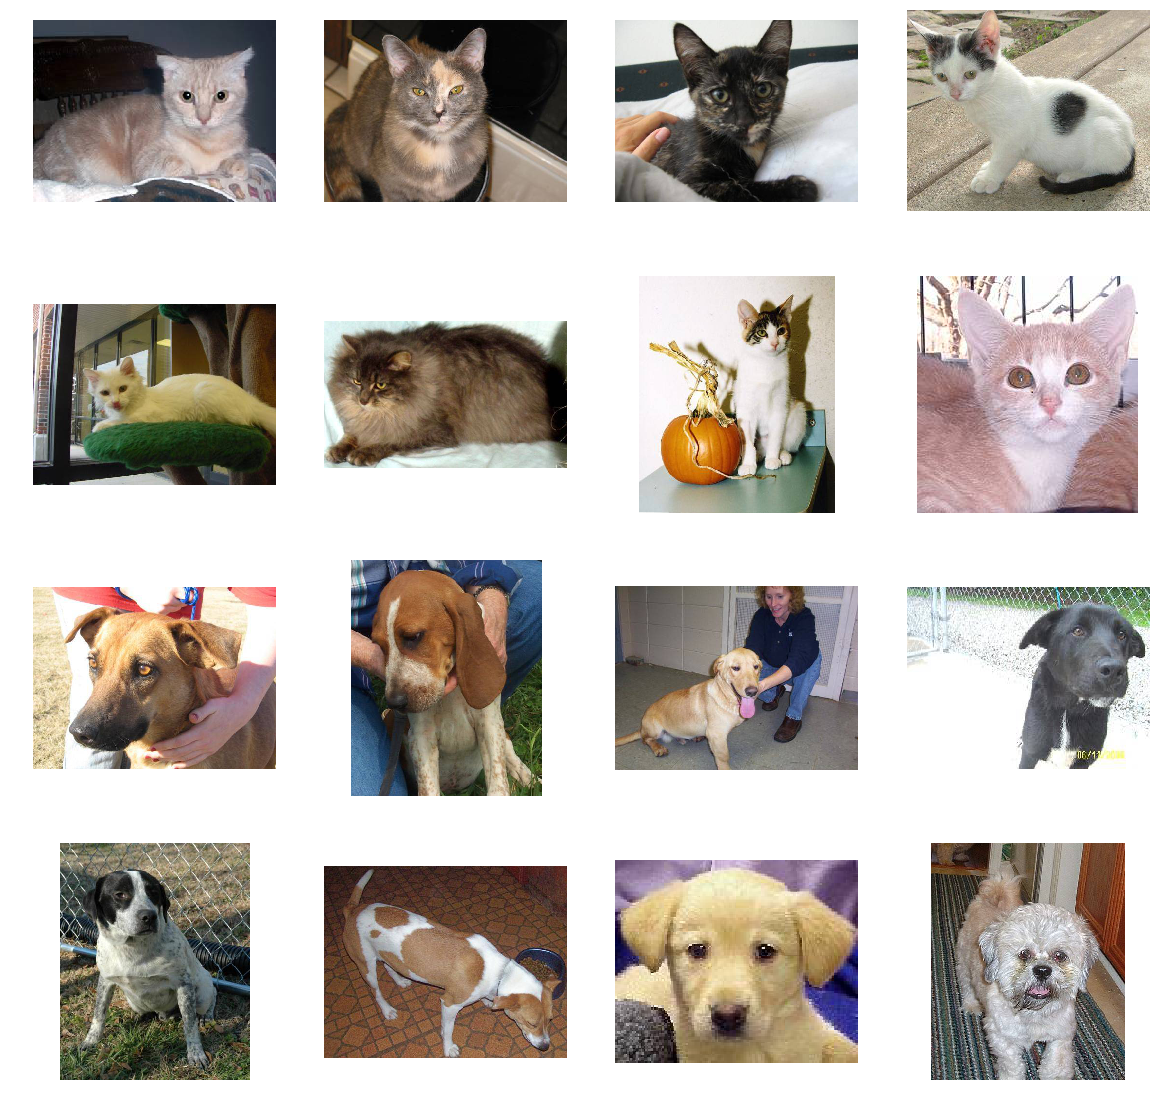

In [144]:
fig = plt.gcf()
fig.set_size_inches(20,20)
rand=random.randint(0,492)
for i,img in enumerate(catimg[rand:rand+8]+dogimg[rand:rand+8]):
  plt.subplot(4,4,i+1)
  plt.axis('Off')
  image = mpimg.imread(img)
  plt.imshow(image)

#Model

In [0]:
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [0]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(2, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [148]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 33, 33, 32)        9248

#Training

In [149]:
history = model.fit_generator(
      train_batches,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=200,
      validation_data=valid_batches,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/200
100/100 - 9s - loss: 0.7528 - acc: 0.5295 - val_loss: 0.6946 - val_acc: 0.4950
Epoch 2/200
100/100 - 8s - loss: 0.7024 - acc: 0.5220 - val_loss: 0.6829 - val_acc: 0.5290
Epoch 3/200
100/100 - 8s - loss: 0.6886 - acc: 0.5545 - val_loss: 0.6544 - val_acc: 0.6310
Epoch 4/200
100/100 - 8s - loss: 0.6819 - acc: 0.5945 - val_loss: 0.6262 - val_acc: 0.6420
Epoch 5/200
100/100 - 8s - loss: 0.6545 - acc: 0.6395 - val_loss: 0.6175 - val_acc: 0.6680
Epoch 6/200
100/100 - 8s - loss: 0.6436 - acc: 0.6310 - val_loss: 0.6473 - val_acc: 0.5900
Epoch 7/200
100/100 - 8s - loss: 0.6233 - acc: 0.6485 - val_loss: 0.6182 - val_acc: 0.6570
Epoch 8/200
100/100 - 8s - loss: 0.6328 - acc: 0.6650 - val_loss: 0.6040 - val_acc: 0.6890
Epoch 9/200
100/100 - 8s - loss: 0.6341 - acc: 0.6720 - val_loss: 0.5897 - val_acc: 0.6900
Epoch 10/200
100/100 - 8s - loss: 0.5967 - acc: 0.6900 - val_loss: 0.5952 - val_acc: 0.6980
Epoch 11/200
100/100 - 8s - loss: 0.6215 - acc: 0.6740 - val_loss: 0.6006 - val_acc: 0.69

In [0]:
model.predict(cv2.resize(mpimg.imread(catimg[32]),(150,150)).reshape(1,150,150,3))

array([[0., 1.]], dtype=float32)

In [151]:
img=dogimg+catimg
len(img)

2000

Cat


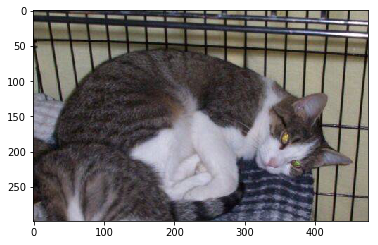

In [165]:
index=random.randint(0,1999)
image = mpimg.imread(img[index])
plt.imshow(image)
if model.predict(cv2.resize(image,(150,150)).reshape(1,150,150,3))[:,0]==1:
  print("Cat")
else:
  print("Dog")